In [1]:
import datetime
import geopandas as gpd
import itertools
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sys
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

/home/chriscarey/miniconda3/envs/mlc/lib/python3.7/site-packages/geopandas/_compat.py:53: UserWarning: The installed version of PyGEOS is too old (0.5 installed, 0.8 required), and thus GeoPandas will not use PyGEOS.
  UserWarning,


In [2]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
LIB_DIR = '../../lib'
LOG_DIR = '../../../log'

In [3]:
# Custom imports
sys.path.append(LIB_DIR)
from gtfs_sequence import Sequence

In [4]:
def peek(df):
    print(len(df))
    display(df.iloc[:3])

# 1. Collect Stop Sequences

Stop sequences are collected by:
<ol>
  <li>Collecting unique stop sequences from <code>stop_times.txt</code>
  <li>Collecting all trip IDs matching a sequence, for each sequence
  <li>Assigning attributes (e.g. route ID) to each stop sequence based on the commonly observed attribute value within each sequence's matching trips
</ol>

This approach is necessary due to mislabelled data. Rather than rely on potentially mislabelled trips, this approach groups trips based on their published stop times and locations, and then labels their routes based on majority of matched labels. This approach corrects for trips following a route, but mislabelled as a different route. Correctly determining the route to which a trip belongs enables matching the stop sequence of the trip to a predefined route geometry.

In [5]:
# Extract stops used for each trip.
stop_times_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/stop_times.txt')
stop_times_df = stop_times_df[['trip_id', 'stop_id', 'arrival_time']]
peek(stop_times_df)

934109


,trip_id,stop_id,arrival_time
0,MQ_C1-Weekday-032400_M57_451,400745,05:24:00
1,MQ_C1-Weekday-032400_M57_451,402233,05:25:30
2,MQ_C1-Weekday-032400_M57_451,403986,05:26:44


In [6]:
# Convert to/from a stop sequence.
def serialize_stop_ids(stop_ids):
    return ','.join([str(s) for s in stop_ids])
def deserialize_stops_key(stops_key):
    return [int(s) for s in stops_key.split(',')]

In [7]:
# Create dictionary of trip ID to stop sequence.
trip_id_stop_ids_dict = stop_times_df.groupby('trip_id').apply(
    lambda x: list(x['stop_id'])).to_dict()

# Serialize stop sequences.
trip_id_stops_key_dict = {
    trip_id: serialize_stop_ids(stop_ids)
    for trip_id, stop_ids in trip_id_stop_ids_dict.items()
}

# Map stop sequences to list of matching trips.
stops_key_trip_ids_dict = {}
for trip_id, stops_key in trip_id_stops_key_dict.items():
    if stops_key not in stops_key_trip_ids_dict:
        stops_key_trip_ids_dict[stops_key] = []
    stops_key_trip_ids_dict[stops_key].append(trip_id)

In [8]:
# Extract information for each trip.
trips_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/trips.txt')
trips_df = trips_df.set_index('trip_id')
trip_id_route_id_dict = trips_df['route_id'].to_dict()
peek(trips_df)

29055


,route_id,service_id,trip_headsign,direction_id,shape_id
trip_id,,,,,
MQ_C1-Weekday-032400_M57_451,M57,MQ_C1-Weekday,WEST SIDE BROADWAY-72 ST CROSSTOWN,1,M570110
MQ_C1-Weekday-034000_M57_451,M57,MQ_C1-Weekday,EAST SIDE YORK-60 ST CROSSTOWN,0,M570111
MQ_C1-Weekday-037300_M57_451,M57,MQ_C1-Weekday,WEST SIDE BROADWAY-72 ST CROSSTOWN,1,M570109


In [9]:
# Create sequences from map of stops and matching trips.
sequences = [
    Sequence(deserialize_stops_key(stops_key), trip_ids, trips_df)
    for stops_key, trip_ids in tqdm(stops_key_trip_ids_dict.items())
]

100%|██████████| 146/146 [00:13<00:00, 10.83it/s]


# 2. Assign Stop Locations Along Route Geometry

The locations of stops are provided in `stops.txt`, but must be "snapped" to the closest point along a route geometry for linear referencing and time interpolation. Because stops may be shared by multiple routes, "snapped" stop locations may be different for each route. Therefore, a manifest of stop locations per route is calculated. If the distance between a provided stop location and its route-snapped location exceeds a distance threshold, an error is thrown to flag it as potentially inaccurate.

In [10]:
# Load stop locations into DataFrame.
stops_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/stops.txt')
stops_df = stops_df.set_index('stop_id')
stops_df = stops_df[['stop_lat', 'stop_lon']]
peek(stops_df)

1808


,stop_lat,stop_lon
stop_id,,
400001,40.731342,-73.990292
400002,40.732608,-73.989958
400003,40.733936,-73.989720


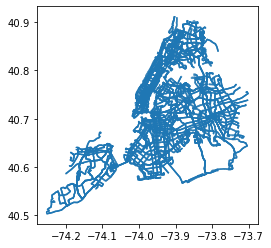

In [11]:
# Load bus route geometries into DataFrame.
routes_gdf = gpd.read_file(f'{DATA_DIR}/shp/bus_routes_nyc_may2020.shp')
routes_gdf = routes_gdf.to_crs(CRS_LATLON)
routes_gdf.plot()
plt.show()

In [12]:
# Assign route geometries and only keep sequences with matching geometries.
print(f'# of sequences before route geometry assignement: {len(sequences)}')
sequences = [s for s in sequences if s.assign_route_geometry(routes_gdf)]
print(f'# of sequences after route geometry assignement: {len(sequences)}')

# of sequences before route geometry assignement: 146
# of sequences after route geometry assignement: 144


In [13]:
for sequence in sequences:
    sequence.assign_stop_coords(stops_df)

<AxesSubplot:>

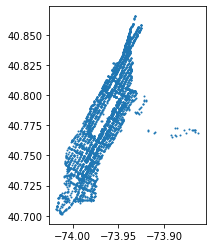

In [14]:
# Check all stop coordinates by plotting.
all_stop_coords = list(itertools.chain(*[s.stop_coords for s in sequences]))
gpd.GeoDataFrame({}, geometry=all_stop_coords, crs=CRS_LATLON).plot(markersize=1)

# 3. Assign Bus Arrival Times

The bus arrival times by trip are collected for every stop. This allows the
average bus travel speed between two stops belonging to the same trip to be
estimated.

In [15]:
def get_datetime_from_time_string(time_string):
    """Returns a datetime object of the time since 1 Jan 1970 given by the
    HH:MM:SS formatted string."""
    hours = int(time_string[0:2])
    mins = int(time_string[3:5])
    secs = int(time_string[6:8])
    
    # GTFS data may include hour values greater than 23 in order to indicate a
    # time occurring on the next day.
    if hours < 24:
        return datetime.datetime(1970, 1, 1, hours, mins, secs)
    return datetime.datetime(1970, 1, 2, hours % 24, mins, secs)

In [16]:
def find_sequence(trip_id, trip_id_sequence_dict):
    if trip_id not in trip_id_sequence_dict:
        for sequence in sequences:
            if sequence.has_trip_id(trip_id):
                trip_id_sequence_dict[trip_id] = sequence
                break
    if trip_id not in trip_id_sequence_dict:
        return None
    return trip_id_sequence_dict[trip_id]

In [17]:
trip_ids_and_times = list(zip(stop_times_df['trip_id'], stop_times_df['arrival_time']))

In [18]:
trip_id_sequence_dict = {}
unmatched_trip_ids = []

for (trip_id, time) in tqdm(trip_ids_and_times):
    # Get the sequence with the given trip ID. Cache for later.
    sequence = find_sequence(trip_id, trip_id_sequence_dict)
    
    if sequence:
        # Adds time to sequence by trip ID.
        if trip_id not in sequence.trip_times_dict:
            sequence.trip_times_dict[trip_id] = []
        dt = get_datetime_from_time_string(time)
        sequence.trip_times_dict[trip_id].append(dt)
    else:
        unmatched_trip_ids.append(trip_id)

# Logs unmatched trip IDs.
with open(f'{LOG_DIR}/unmatched_trip_ids.json', 'w') as fp:
    json.dump(unmatched_trip_ids, fp)

100%|██████████| 934109/934109 [00:01<00:00, 607849.50it/s]


# 4. Calculate Bus Average Travel Speeds

The bus average travel speeds along a trip are calculated using the scheduled time duration between each stop, and the distance along the route between each stop.

In [19]:
for sequence in tqdm(sequences):
    sequence.calculate_trip_speeds()

100%|██████████| 144/144 [00:00<00:00, 297.99it/s]


# 5. Inspect Sample

Check extracted values of sample to make sure that they are formatted as expected.

In [34]:
len(sequences)

144

In [20]:
sample = sequences[0]

### 5.1 Route Information

In [21]:
sample.route_id

'M14D+'

In [22]:
sample.direction_id

0

In [23]:
sample.length

23

In [24]:
sample.stop_ids[0:10]

[450222,
 401507,
 404286,
 401575,
 401294,
 401577,
 401579,
 403556,
 401191,
 401192]

### 5.2 Route Geometry

In [25]:
sample.stop_coords[0:10]

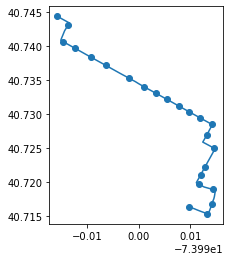

In [26]:
fig, ax = plt.subplots()
gpd.GeoDataFrame({}, geometry=[sample.route_geometry], crs=CRS_LATLON).plot(ax=ax)
gpd.GeoDataFrame({}, geometry=sample.stop_coords, crs=CRS_LATLON).plot(ax=ax)
plt.show()

In [27]:
sample.stop_distances[0:10]

[0,
 271.36787938318696,
 292.7133050173731,
 286.8859659001768,
 373.50788045801283,
 338.9263611280805,
 535.8189080249559,
 361.8084733308834,
 260.2865006902442,
 261.9654932902139]

### 5.3 Trip Attributes

In [28]:
len(sample.trip_ids)

695

In [29]:
sample.trip_ids[0:10]

['MQ_C1-Saturday-002900_SBS14_701',
 'MQ_C1-Saturday-008900_SBS14_701',
 'MQ_C1-Saturday-014900_SBS14_701',
 'MQ_C1-Saturday-020900_SBS14_701',
 'MQ_C1-Saturday-026500_SBS14_703',
 'MQ_C1-Saturday-029500_SBS14_705',
 'MQ_C1-Saturday-031500_SBS14_701',
 'MQ_C1-Saturday-033000_SBS14_703',
 'MQ_C1-Saturday-034500_SBS14_707',
 'MQ_C1-Saturday-036000_SBS14_705']

#### Arrival times

In [30]:
[(k, [t.isoformat()[11:] for t in v[0:5]]) for [k, v] in list(sample.trip_times_dict.items())[0:10]]

[('MQ_C1-Weekday-003000_SBS14_701',
  ['00:30:00', '00:31:20', '00:33:00', '00:33:56', '00:35:26']),
 ('MQ_C1-Weekday-009200_SBS14_701',
  ['01:32:00', '01:32:53', '01:34:00', '01:34:48', '01:36:05']),
 ('MQ_C1-Weekday-015200_SBS14_701',
  ['02:32:00', '02:32:53', '02:34:00', '02:34:48', '02:36:05']),
 ('MQ_C1-Weekday-021200_SBS14_701',
  ['03:32:00', '03:32:53', '03:34:00', '03:34:48', '03:36:05']),
 ('MQ_C1-Weekday-027000_SBS14_701',
  ['04:30:00', '04:30:53', '04:32:00', '04:32:48', '04:34:05']),
 ('MQ_C1-Weekday-037100_SBS14_716',
  ['06:11:00', '06:11:53', '06:13:00', '06:13:56', '06:15:26']),
 ('MQ_C1-Weekday-025500_SBS14_703',
  ['04:15:00', '04:15:53', '04:17:00', '04:17:48', '04:19:05']),
 ('MQ_C1-Weekday-032000_SBS14_703',
  ['05:20:00', '05:20:53', '05:22:00', '05:22:48', '05:24:05']),
 ('MQ_C1-Weekday-040600_SBS14_711',
  ['06:46:00', '06:47:20', '06:49:00', '06:50:12', '06:52:08']),
 ('MQ_C1-Weekday-049700_SBS14_727',
  ['08:17:00', '08:18:47', '08:21:00', '08:22:12', '08:

#### Time durations between stops

In [31]:
[(k, v[0:10]) for [k, v] in list(sample.trip_durations_dict.items())[0:10]]

[('MQ_C1-Weekday-003000_SBS14_701',
  [0, 80.0, 100.0, 56.0, 90.0, 75.0, 119.0, 80.0, 54.0, 53.0]),
 ('MQ_C1-Weekday-009200_SBS14_701',
  [0, 53.0, 67.0, 48.0, 77.0, 65.0, 101.0, 69.0, 39.0, 40.0]),
 ('MQ_C1-Weekday-015200_SBS14_701',
  [0, 53.0, 67.0, 48.0, 77.0, 65.0, 101.0, 69.0, 39.0, 40.0]),
 ('MQ_C1-Weekday-021200_SBS14_701',
  [0, 53.0, 67.0, 48.0, 77.0, 65.0, 101.0, 69.0, 39.0, 40.0]),
 ('MQ_C1-Weekday-027000_SBS14_701',
  [0, 53.0, 67.0, 48.0, 77.0, 65.0, 101.0, 69.0, 46.0, 47.0]),
 ('MQ_C1-Weekday-037100_SBS14_716',
  [0, 53.0, 67.0, 56.0, 90.0, 75.0, 119.0, 80.0, 54.0, 53.0]),
 ('MQ_C1-Weekday-025500_SBS14_703',
  [0, 53.0, 67.0, 48.0, 77.0, 65.0, 101.0, 69.0, 39.0, 40.0]),
 ('MQ_C1-Weekday-032000_SBS14_703',
  [0, 53.0, 67.0, 48.0, 77.0, 65.0, 101.0, 69.0, 46.0, 47.0]),
 ('MQ_C1-Weekday-040600_SBS14_711',
  [0, 80.0, 100.0, 72.0, 116.0, 97.0, 152.0, 103.0, 57.0, 57.0]),
 ('MQ_C1-Weekday-049700_SBS14_727',
  [0, 107.0, 133.0, 72.0, 116.0, 97.0, 152.0, 103.0, 68.0, 68.0])]

#### Average travel speeds between stops

In [32]:
[(k, [round(s, 2)
      for s in v[0:10]])
 for [k, v] in list(sample.trip_speeds_dict.items())[0:10]]

[('MQ_C1-Weekday-003000_SBS14_701',
  [0, 3.39, 2.93, 5.12, 4.15, 4.52, 4.5, 4.52, 4.82, 4.94]),
 ('MQ_C1-Weekday-009200_SBS14_701',
  [0, 5.12, 4.37, 5.98, 4.85, 5.21, 5.31, 5.24, 6.67, 6.55]),
 ('MQ_C1-Weekday-015200_SBS14_701',
  [0, 5.12, 4.37, 5.98, 4.85, 5.21, 5.31, 5.24, 6.67, 6.55]),
 ('MQ_C1-Weekday-021200_SBS14_701',
  [0, 5.12, 4.37, 5.98, 4.85, 5.21, 5.31, 5.24, 6.67, 6.55]),
 ('MQ_C1-Weekday-027000_SBS14_701',
  [0, 5.12, 4.37, 5.98, 4.85, 5.21, 5.31, 5.24, 5.66, 5.57]),
 ('MQ_C1-Weekday-037100_SBS14_716',
  [0, 5.12, 4.37, 5.12, 4.15, 4.52, 4.5, 4.52, 4.82, 4.94]),
 ('MQ_C1-Weekday-025500_SBS14_703',
  [0, 5.12, 4.37, 5.98, 4.85, 5.21, 5.31, 5.24, 6.67, 6.55]),
 ('MQ_C1-Weekday-032000_SBS14_703',
  [0, 5.12, 4.37, 5.98, 4.85, 5.21, 5.31, 5.24, 5.66, 5.57]),
 ('MQ_C1-Weekday-040600_SBS14_711',
  [0, 3.39, 2.93, 3.98, 3.22, 3.49, 3.53, 3.51, 4.57, 4.6]),
 ('MQ_C1-Weekday-049700_SBS14_727',
  [0, 2.54, 2.2, 3.98, 3.22, 3.49, 3.53, 3.51, 3.83, 3.85])]

# 6. Export Results

Preserve in JSON format for flexible object creation.

In [33]:
sequence_dicts = [s.to_dict() for s in sequences]
with open(f'{EXPORTS_DIR}/json/manhattan/sequence_dicts.json', 'w') as fp:
    json.dump(sequence_dicts, fp)